## Этап 1: Предобработка данных

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve


In [6]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Обзорная информация о выборке 
Длинна выборки: 10000  
Число ушедших клиентов: 2037  (отмечаю дисбаланс классов).   
Типы данных указаны верно.   

### UPD.   
**Пропуски есть в признке Tenure (количество недвижимости у клиента).  Буду заполнять нулями.**  

## Этап 2: Подготовка данных к обучению

In [7]:
data['Tenure'] = data['Tenure'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [8]:
data_ohe = pd.get_dummies(data[['Geography', 'Gender']], drop_first = True)
data = data.join(data_ohe).copy()



In [9]:
data = data.drop(['Surname','Geography','Gender','RowNumber', 'CustomerId'], 1).copy()
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


##### Комментарии по преобразованию
Была применена функция pd.get_dummies для категориальных прихзнаков 'Geography','Gender', как дублирующие.  
Также были удалены Surname, CustomerId, поскольку их роль в качествк признака, заслуживающего внимания, сомнительна.  

In [10]:
from sklearn.preprocessing import StandardScaler

target = data['Exited']
features = data.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)


In [11]:
features_valid, features_control, target_valid, target_control = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345)

### Разделение выборок  
Исходная выборка была разделена на обучающую, валидационную и контрольную выборку для финального теста.    

In [12]:
pd.options.mode.chained_assignment = None
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_control[numeric] = scaler.transform(features_control[numeric])

features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
226,0.442805,-0.841274,1.426885,-1.224577,0.817772,1,1,-1.269750,0,0,0
7756,-0.310897,-0.270730,0.784858,0.641783,-0.896874,1,1,0.960396,0,1,0
2065,-0.259274,-0.556002,1.105871,-1.224577,0.817772,1,0,0.661864,0,0,1
2800,1.217157,1.155631,1.426885,1.290462,0.817772,1,0,-1.039476,0,0,1
7028,0.690598,-1.221637,-1.462240,1.142121,-0.896874,0,0,-0.851729,1,0,1


### Масштабированию признаков. 
Было проведено масштабирование числовых признаков 'CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary'

## Этап 3: Тестирование моделей

#### Подготовка увеличенной и уменьшенной выборок  
Потребуются для обучения модели и устранения дисбаланса классов. 

In [13]:
def upsample(features, target, repeat): 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 100)

In [14]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

#### Дерево решенией

In [15]:
model = DecisionTreeClassifier(random_state=12345) #можно убрать баланс послое увелич выборки
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
dec_tree_auc_roc = roc_auc_score(target_valid, predicted_valid)

f1_dec_tree_train = f1_score(target_valid, predicted_valid)
print('Метрики Дерева решений')
print('F1:', f1_dec_tree_train)
print('AUR-ROC:', dec_tree_auc_roc)


Метрики Дерева решений
F1: 0.47970479704797053
AUR-ROC: 0.6716670326410639


In [16]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
dec_tree_auc_roc_up = roc_auc_score(target_valid, predicted_valid)

f1_dec_tree_train_up = f1_score(target_valid, predicted_valid)
print('Метрики Дерева решений, обученной по увеличенной выборке')
print('F1:', f1_dec_tree_train_up)
print('AUR-ROC:', dec_tree_auc_roc_up)

Метрики Дерева решений, обученной по увеличенной выборке
F1: 0.4708333333333333
AUR-ROC: 0.6621439935896695


In [17]:
model = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
random_forest_auc_roc = roc_auc_score(target_valid, predicted_valid)

f1_dec_tree_train = f1_score(target_valid, predicted_valid)
print('Метрики Дерева решений, обученной по увеличенной выборке + сбалансирован класс')
print('F1:', f1_score(target_valid, predicted_valid))
print('AUR-ROC:', random_forest_auc_roc)

Метрики Дерева решений, обученной по увеличенной выборке + сбалансирован класс
F1: 0.5245283018867923
AUR-ROC: 0.6994155966731002


In [19]:
for m in range(1,30,2):
    model = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced', max_depth = m)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    random_forest_auc_roc = roc_auc_score(target_valid, predicted_valid)

    f1_dec_tree_train = f1_score(target_valid, predicted_valid)
    print('max_depth:', m, 'F1:', f1_dec_tree_train, 'AUR-ROC:', random_forest_auc_roc)

max_depth: 1 F1: 0.4864 AUR-ROC: 0.6825904053070141
max_depth: 3 F1: 0.5314900153609832 AUR-ROC: 0.7199814316147946
max_depth: 5 F1: 0.6035889070146819 AUR-ROC: 0.7681244004761519
max_depth: 7 F1: 0.5655172413793105 AUR-ROC: 0.7595413377712544
max_depth: 9 F1: 0.5751824817518247 AUR-ROC: 0.7605429519109641
max_depth: 11 F1: 0.5426356589147288 AUR-ROC: 0.7278363978873647
max_depth: 13 F1: 0.53 AUR-ROC: 0.7121091297128834
max_depth: 15 F1: 0.5263157894736843 AUR-ROC: 0.7056371614255281
max_depth: 17 F1: 0.5230202578268875 AUR-ROC: 0.7000531625966462
max_depth: 19 F1: 0.51024208566108 AUR-ROC: 0.6910540447875615
max_depth: 21 F1: 0.5269016697588126 AUR-ROC: 0.7020795050485205
max_depth: 23 F1: 0.5122410546139359 AUR-ROC: 0.6916858321679938
max_depth: 25 F1: 0.527306967984934 AUR-ROC: 0.7013167373575109
max_depth: 27 F1: 0.5245283018867923 AUR-ROC: 0.6994155966731002
max_depth: 29 F1: 0.5245283018867923 AUR-ROC: 0.6994155966731002


### Выводы по Дереву решений:  

Максимальное значение F1 составило 0.6035889070146819 при активации class_weight = 'balanced'  
и гиперпараметре max_depth = 5

Значение AUR-ROC при этом = 0.7681244004761519  

#### Логистическая регрессия

In [20]:
log_reg_model = LogisticRegression(
    random_state=12345, solver = 'lbfgs').fit(features_train, target_train)
log_reg_predicted_valid = log_reg_model.predict(features_valid)
log_reg_train_auc_roc = roc_auc_score(target_valid, log_reg_predicted_valid)
f1_log_reg_train = f1_score(target_valid, log_reg_predicted_valid)


print('Метрики Логистической регрессии без учёта дисбаланса классов')
print('F1:', f1_log_reg_train)
print('AUR-ROC:', log_reg_train_auc_roc)

Метрики Логистической регрессии без учёта дисбаланса классов
F1: 0.29295774647887324
AUR-ROC: 0.5785958910706098


In [22]:
log_reg_model = LogisticRegression(
    random_state=12345, solver = 'lbfgs').fit(features_upsampled, target_upsampled)
log_reg_predicted_valid = log_reg_model.predict(features_valid)
log_reg_auc_roc = roc_auc_score(target_valid, log_reg_predicted_valid)
f1_log_reg = f1_score(target_valid, log_reg_predicted_valid)


print('Метрики Логистической регрессии, обученной по увеличенной выборке')
print('F1:', f1_log_reg)
print('AUR-ROC:', log_reg_auc_roc)

Метрики Логистической регрессии, обученной по увеличенной выборке
F1: 0.34788359788359785
AUR-ROC: 0.5005065856129686


In [23]:
log_reg_model = LogisticRegression(
    random_state=12345, solver = 'lbfgs', class_weight = 'balanced').fit(features_upsampled, target_upsampled)
log_reg_predicted_valid = log_reg_model.predict(features_valid)
log_reg_train_auc_roc = roc_auc_score(target_valid, log_reg_predicted_valid)
f1_log_reg_train = f1_score(target_valid, log_reg_predicted_valid)


print('Метрики Логистической регрессии, обученной по увеличенной выборке')
print('F1:', f1_log_reg_train)
print('AUR-ROC:', log_reg_train_auc_roc)



Метрики Логистической регрессии, обученной по увеличенной выборке
F1: 0.5132978723404255
AUR-ROC: 0.7169708106525516


### Выводы по Логистической регрессии:  
Параметр F1 удалось разогнать с 0.29295774647887324 до 0.5132978723404255 (AUR-ROC: 0.7169708106525516),  
благодаря обучению по увеличенной выборке, а также применению class_weight = 'balanced'.

#### Случайный лес

In [24]:
random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=5, )
random_forest_model.fit(features_train, target_train)
random_forest_predict = random_forest_model.predict(features_valid)
f1_rand_for_train = f1_score(target_valid, random_forest_predict)
auc_roc_rand_for_train = roc_auc_score(target_valid, random_forest_predict)

print('Метрики модели Случайный лес без учёта дисбаланса классов')
print('F1:', f1_rand_for_train)
print('AUR-ROC:', auc_roc_rand_for_train)


Метрики модели Случайный лес без учёта дисбаланса классов
F1: 0.5357142857142858
AUR-ROC: 0.695208817286319


In [25]:
upsampled_random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=5)
upsampled_random_forest_model.fit(features_upsampled, target_upsampled)
upsampled_random_forest_predict = upsampled_random_forest_model.predict(features_valid)
f1_rand_for_upsampled= f1_score(target_valid, upsampled_random_forest_predict)
auc_roc_rand_for_upsampled = roc_auc_score(target_valid, upsampled_random_forest_predict)

print('Метрики модели Случайный лес по увеличенной выборке')
print('F1:', f1_rand_for_upsampled)
print('AUR-ROC:', auc_roc_rand_for_upsampled)

Метрики модели Случайный лес по увеличенной выборке
F1: 0.5514403292181069
AUR-ROC: 0.709666732156822


In [26]:
downsampled_random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=5)
downsampled_random_forest_model.fit(features_downsampled, target_downsampled)
downsampled_random_forest_predict = downsampled_random_forest_model.predict(features_valid)
f1_rand_for_downsampled = f1_score(target_valid, downsampled_random_forest_predict)
auc_roc_rand_for_downsampled= roc_auc_score(target_valid, downsampled_random_forest_predict)

print('Метрики модели Случайный лес по уменьшенной выборке')
print('F1:', f1_rand_for_downsampled)
print('AUR-ROC:', auc_roc_rand_for_downsampled)

Метрики модели Случайный лес по уменьшенной выборке
F1: 0.46766169154228865
AUR-ROC: 0.6899291550614258


#### Подборка параметров для Случайного леса в цикле  
При этом добавляется min_samples_leaf = 5, чтобы снизить эффект переобучения, а также class_weight = 'balanced'.  

##### Первая итерация улучшения

In [27]:
for e in range(1,300,15):
    random_forest_model = RandomForestClassifier(
        random_state=12345, n_estimators= e, min_samples_leaf = 5, class_weight = 'balanced')
    random_forest_model.fit(features_upsampled, target_upsampled)
    random_forest_predict = random_forest_model.predict(features_valid)
    f1_metric = f1_score(target_valid, random_forest_predict)
    auc_roc_rand_for = roc_auc_score(target_valid, random_forest_predict)
    if f1_metric > 0.6:
        print('If n_estimators =', e, "F1 (upsampled data) =", f1_metric, 'AUR-ROC:', auc_roc_rand_for)  

If n_estimators = 16 F1 (upsampled data) = 0.6219931271477663 AUR-ROC: 0.7741976492886614
If n_estimators = 31 F1 (upsampled data) = 0.6347517730496454 AUR-ROC: 0.7785007377273374
If n_estimators = 46 F1 (upsampled data) = 0.6300884955752213 AUR-ROC: 0.7755864258169896
If n_estimators = 61 F1 (upsampled data) = 0.627659574468085 AUR-ROC: 0.7736852851325791
If n_estimators = 76 F1 (upsampled data) = 0.6285714285714286 AUR-ROC: 0.7733039012870742
If n_estimators = 91 F1 (upsampled data) = 0.635379061371841 AUR-ROC: 0.7763434149648857
If n_estimators = 106 F1 (upsampled data) = 0.6365280289330922 AUR-ROC: 0.7768500005778542
If n_estimators = 121 F1 (upsampled data) = 0.6340579710144928 AUR-ROC: 0.7749488598934438
If n_estimators = 136 F1 (upsampled data) = 0.6338797814207651 AUR-ROC: 0.7740608904349703
If n_estimators = 151 F1 (upsampled data) = 0.6256781193490054 AUR-ROC: 0.7696268216857165
If n_estimators = 166 F1 (upsampled data) = 0.6327272727272727 AUR-ROC: 0.7735543048220016
If n_es

##### Вторая итерация улучшения на основен полученных данных:
Работа в цикле показала, что n_estimators= 271 является оптимальным параметром.  
В условиях n_estimators= 271, class_weight = 'balanced' и min_samples_leaf = 5  
Параметр F1 = 0.6436363636363636, AUR-ROC = 0.7807774837141394.  

In [28]:
max_f1_first_iter = 0.6436363636363636
aur_roc_first_iter = 0.7807774837141394

for i in range(1,30):
    random_forest_model = RandomForestClassifier(
    random_state=12345, n_estimators= 271, max_depth= i, min_samples_leaf = 5, class_weight = 'balanced')
    random_forest_model.fit(features_upsampled, target_upsampled)
    random_forest_predict = random_forest_model.predict(features_valid)
    f1_metric = f1_score(target_valid, random_forest_predict)
    auc_roc_rand_for = roc_auc_score(target_valid, random_forest_predict)
    if f1_metric > 0.6:
        print('max_depth =', i, "F1 (upsampled data) =", f1_metric, 'AUR-ROC = ', auc_roc_rand_for)

max_depth = 3 F1 (upsampled data) = 0.6067073170731708 AUR-ROC =  0.780049387281812
max_depth = 4 F1 (upsampled data) = 0.6094946401225114 AUR-ROC =  0.7815691441207178
max_depth = 5 F1 (upsampled data) = 0.6137404580152672 AUR-ROC =  0.785371425489539
max_depth = 6 F1 (upsampled data) = 0.6300940438871474 AUR-ROC =  0.793983380910005
max_depth = 7 F1 (upsampled data) = 0.637223974763407 AUR-ROC =  0.7984174496592586
max_depth = 8 F1 (upsampled data) = 0.6498422712933755 AUR-ROC =  0.8080483548487756
max_depth = 9 F1 (upsampled data) = 0.6397415185783523 AUR-ROC =  0.7963853286642704
max_depth = 10 F1 (upsampled data) = 0.6533996683250415 AUR-ROC =  0.8020829721743886
max_depth = 11 F1 (upsampled data) = 0.6452702702702703 AUR-ROC =  0.7932090561327678
max_depth = 12 F1 (upsampled data) = 0.6458333333333334 AUR-ROC =  0.789275794453369
max_depth = 13 F1 (upsampled data) = 0.6315789473684211 AUR-ROC =  0.7778689503469052
max_depth = 14 F1 (upsampled data) = 0.627659574468085 AUR-ROC =  

In [29]:
aur_roc_second_iter = 0.8020829721743886

final_model_random_forest = RandomForestClassifier(
    random_state=12345, n_estimators= 271, max_depth= 10, min_samples_leaf = 5, class_weight = 'balanced')
final_model_random_forest.fit(features_upsampled, target_upsampled)
final_model_random_forest_predict = final_model_random_forest.predict(features_valid)
f1_rand_for_final = f1_score(target_valid, final_model_random_forest_predict)
auc_roc_rand_for_final = roc_auc_score(target_valid, final_model_random_forest_predict)

print('Метрики финализированной модели Случайный лес')
print('F1:', f1_rand_for_final)
print('AUR-ROC:', auc_roc_rand_for_final)

Метрики финализированной модели Случайный лес
F1: 0.6533996683250415
AUR-ROC: 0.8020829721743886


In [31]:
control_random_forest_predict = final_model_random_forest.predict(features_control)
f1_rand_for_control = f1_score(target_control, control_random_forest_predict)
auc_roc_rand_for_control = roc_auc_score(target_control, control_random_forest_predict)
print('Метрики финализированной модели Случайный лес по контрольной выборке')
print('F1:', f1_rand_for_control)
print('AUR-ROC:', auc_roc_rand_for_control)

Метрики финализированной модели Случайный лес по контрольной выборке
F1: 0.6317460317460318
AUR-ROC: 0.7845204799711295


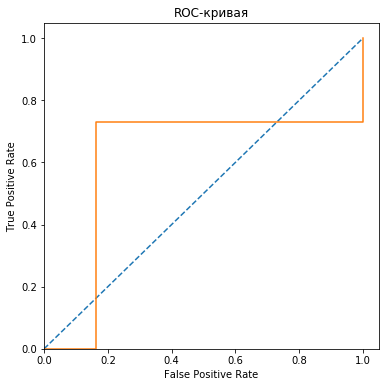

In [35]:
fpr, tpr, thresholds = roc_curve(target_control, control_random_forest_predict)
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.step(fpr, tpr, where='post')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()



In [33]:
rand_for_result = pd.DataFrame.from_dict({'Iterations': [
    'Train', 'Upsamled', 'Downsampled', 'First improvement', 'Second improvement', 'Control'],
                    'F1': [
                        f1_rand_for_train, f1_rand_for_upsampled,
                        f1_rand_for_downsampled, max_f1_first_iter, f1_rand_for_final, f1_rand_for_control],
                    'AUR-ROC': [
                        auc_roc_rand_for_train, auc_roc_rand_for_upsampled,
                        auc_roc_rand_for_downsampled, aur_roc_first_iter, 
                        aur_roc_second_iter, auc_roc_rand_for_control]})



### Выводы по Случайному лесу. 
Модель показала лучшие результаты.  
Стартовые метрики на учебной выборке: F1: 0.5357142857142858, AUR-ROC: 0.695208817286319 
Регулировка гиперпараметров n_estimators = 271 и max_depth= 20, а также добавление min_samples_leaf = 5, class_weight = 'balanced'  
позволили улучшить показатели модели. Во вторую итреацию улучшения показатели на тестовой выборке составили:  
F1: 0.6533996683250415, AUR-ROC: 0.8020829721743886.    
  
На контрольной выборке:  
F1: 0.6317460317460318, AUR-ROC: 0.8020829721743886.   
Таким образом, была достигнута цель проекта (метрика F1 не менее 0.59). AUR-ROC лучше, чем у случайной модели, так как  
превышает 0.5.  

_Динамика изменения метрик модели представлена ниже._

In [34]:
rand_for_result

,Iterations,F1,AUR-ROC
0,Train,0.535714,0.695209
1,Upsamled,0.551440,0.709667
2,Downsampled,0.467662,0.689929
3,First improvement,0.645985,0.781791
4,Second improvement,0.653400,0.802083
5,Control,0.631746,0.784520


### Дополнительные выводы.   
При работе с моделями очень важно на этапе подготовки данных отсечь "лишие" признаки.  
В данном случае таковым являлись 'Surname','RowNumber', 'CustomerId'.  
Изначально была допущена ошибка и был сохранён CustomerId, и в таком случае показатель F1 линейной регрессии был равен 0.  
Это обстоятельство заставило пересмотреть этап подготовки данных.  

Модель Случайный лес показала лучшие результаты после обучения на тренировочной и увеличенной выборке, поэтому в работу  
для дальнейшего улучшения была выбрана именно она.  